In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as sp
import spikeinterface.preprocessing as spre
import spikeinterface.qualitymetrics as qm
import helper_functions as helper

In [5]:
#Reading the file, BP filtering
local_path= '/mnt/disk15tb/mmpatil/Spikesorting/Data/Mandar/230706/18712/Network/000011/data.raw.h5' #network data from chip 16848

recording1 = se.read_maxwell(local_path)



#recording = si.ConcatenateSegmentRecording([recording1,recording2])
channel_ids = recording1.get_channel_ids()
fs = recording1.get_sampling_frequency()
num_chan = recording1.get_num_channels()
num_seg = recording1.get_num_segments()
total_recording = recording1.get_total_duration()

#print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print(f"total_recording: {total_recording} s")

recording_bp = spre.bandpass_filter(recording1, freq_min=300, freq_max=6000)

recodring_cmr = spre.common_reference(recording_bp, reference='global', operator='median')
#recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
print(f"chunk duration: {recording_chunk.get_total_duration()} s")


Sampling frequency: 20000.0
Number of channels: 219
Number of segments: 1
total_recording: 300.03 s
chunk duration: 300.0 s


In [ ]:
default_KS2_params = ss.get_default_sorter_params('kilosort2')
print(default_KS2_params)

In [ ]:

default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 12
default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['preclust_threshold'] = 8
run_sorter = ss.run_kilosort2(recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/ks2Doublesorting/", docker_image= "kilosort2-maxwellcomplib:latest",verbose=True, **default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

In [3]:
sorting_KS2 = ss.Kilosort3Sorter._get_result_from_folder('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/ks2Doublesorting/sorter_output/')
total_units = sorting_KS2.get_unit_ids()
print(total_units)
print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)
channel_association_dict = {int(y):x for x,y in enumerate(channel_ids) }
print(channel_association_dict)

[  0   4   5   6   7   9  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  27  29  30  31  32  33  35  36  37  38  39  40  43  44  45  46
  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  65
  66  67  68  69  71  72  73  75  76  77  78  80  81  82  83  84  85  86
  87  89  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 108]
91
['7' '9' '10' '12' '21' '22' '24' '30' '33' '45' '47' '54' '57' '58' '61'
 '62' '66' '69' '78' '84' '86' '94' '95' '106' '114' '116' '120' '121'
 '129' '131' '145' '154' '158' '168' '180' '181' '186' '207' '221' '232'
 '233' '247' '248' '252' '284' '290' '388' '390' '404' '411' '416' '430'
 '456' '521' '531' '532' '537' '549' '554' '555' '561' '565' '570' '573'
 '574' '582' '585' '588' '589' '594' '598' '601' '606' '607' '614' '618'
 '630' '633' '635' '638' '642' '643' '646' '647' '648' '650' '653' '654'
 '659' '660' '664' '665' '666' '670' '673' '679' '682' '685' '686' '688'
 '689' '691' '701' '703' '709' '714' '716' 

In [4]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)
waveforms = si.extract_waveforms(recording_chunk,sorting_KS2,folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/waveformsDoubleSort',overwrite=True)
print(waveforms)

extract waveforms memmap:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 219 channels - 91 units - 1 segments
  before:60 after:80 n_per_units:500


In [5]:
waveforms = si.load_waveforms('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/waveformsDoubleSort')
print(waveforms)

WaveformExtractor: 219 channels - 91 units - 1 segments
  before:60 after:80 n_per_units:500


In [ ]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
pc = sp.compute_principal_components(waveforms, n_components = 3,load_if_exists=True,**job_kwargs)

In [ ]:
job_kwargs = dict(n_jobs=64, chunk_duration="1s", progress_bar=True)
sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)

In [6]:
import spikeinterface.qualitymetrics as qm

metrics = qm.compute_quality_metrics(waveforms,**job_kwargs)

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:194: RuntimeWarning: divide by zero encountered in scalar divide
  snrs[unit_id] = np.abs(amplitude) / noise
/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:511: UserWarning: Units [0, 4, 13, 19, 21, 22, 23, 27, 29, 36, 39, 49, 51, 61, 82, 87, 89, 92, 96, 97, 98] have too few spikes and amplitude_cutoff is set to NaN
  warnings.warn(f"Units {nan_units} have too few spikes and "


In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
display(metrics)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median
0,12,0.040000,0.8,inf,0.000000,0,0.000000,0,NaN,NaN,81.825256
4,2,0.006667,0.4,inf,0.000000,0,0.000000,0,NaN,NaN,75.531006
5,1386,4.620000,1.0,inf,0.000000,0,0.000000,0,0.080,0.003952,314.712524
6,1253,4.176667,1.0,inf,0.063694,1,0.100601,1,0.170,0.014824,295.829773
7,2264,7.546667,1.0,inf,0.000000,0,0.000000,0,0.035,0.003895,239.181519
9,1015,3.383333,1.0,inf,0.000000,0,0.000000,0,0.040,0.011739,75.531006
12,1362,4.540000,1.0,inf,0.161721,3,0.000000,0,0.075,0.007629,226.593018
13,353,1.176667,1.0,inf,0.000000,0,0.000000,0,0.280,NaN,56.648254
14,1582,5.273333,1.0,inf,0.000000,0,0.000000,0,0.015,0.009355,37.765503
15,2568,8.560000,1.0,inf,0.000000,0,0.000000,0,0.010,0.000678,75.531006


In [8]:
import mea_analysis_pipeline as msp
unit_ids = msp.remove_violated_units(metrics)
print(f"{unit_ids} {len(unit_ids)}")

[  5   6   7   9  12  14  15  16  17  18  20  24  25  30  31  32  35  40
  43  44  45  46  48  52  53  54  55  56  58  59  60  62  63  65  66  67
  68  69  71  72  75  76  77  78  80  81  83  84  85  86  91  93  94  95
  99 100 101 104 105 106 108] 61


In [9]:
redundant_units = msp.remove_similar_templates(waveforms)
print(f"redundant-units : {redundant_units}")
non_violated_units = [item for item in unit_ids if item not in redundant_units]

51 7
redundant-units : [51]


/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/mmp/.local/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


In [10]:
print(non_violated_units)

[5, 6, 7, 9, 12, 14, 15, 16, 17, 18, 20, 24, 25, 30, 31, 32, 35, 40, 43, 44, 45, 46, 48, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69, 71, 72, 75, 76, 77, 78, 80, 81, 83, 84, 85, 86, 91, 93, 94, 95, 99, 100, 101, 104, 105, 106, 108]


In [ ]:
sorting_auto_KS3 = sorting_KS2.select_units()

In [11]:
waveform_good = waveforms.select_units(non_violated_units,new_folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/waveforms_goodDoublesorting')


In [2]:
waveform_good = si.load_waveforms('/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/sorting_7jul/waveforms_goodDoublesorting')

61


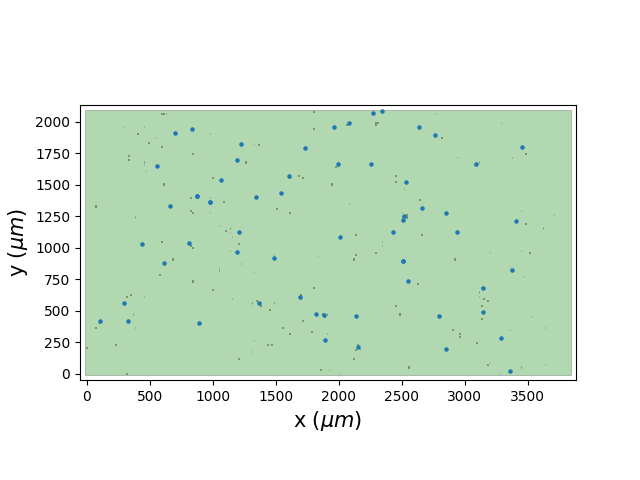

In [6]:
%matplotlib widget
locations = sp.compute_unit_locations(waveform_good)
print(len(locations))
#print(type(locations))
import numpy as np
#np.savetxt("unitloc_10mins.txt",locations)
ax = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
x_values, y_values = zip(*locations)
ax.scatter(x_values, y_values, s=5)
plt.show()

In [14]:
import pickle

with open('/mnt/disk15tb/mmpatil/MEA_Analysis/Python/electrodes_6Jul.pkl','rb') as file:
    electrodes = pickle.load(file)

print(electrodes)
plt.cla()
ax3 = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax3,with_channel_ids=False)

x_values, y_values = zip(*FR_location)
ax3.scatter(x_values, y_values, color='black', s=5,label ='Firing Rate')

ax3.legend()
plt.show()

[10752, 26118, 12807, 18955, 22539, 12301, 15375, 4624, 18, 23571, 13334, 2583, 14363, 22048, 4129, 4642, 546, 21029, 550, 7718, 1062, 7726, 5679, 8759, 8760, 1088, 9288, 1609, 2640, 24657, 21076, 19031, 23128, 24666, 16477, 12894, 12385, 11363, 11364, 4709, 16996, 25199, 25200, 15985, 115, 25211, 25212, 1661, 8318, 3708, 17531, 23701, 9878, 21146, 13982, 10400, 17059, 5286, 22694, 7337, 9386, 26283, 24752, 5299, 25268, 19637, 16052, 22199, 15544, 3257, 4282, 187, 14012, 11965, 18624, 6340, 5828, 7878, 21192, 26314, 16586, 13005, 9933, 18128, 5842, 11479, 19672, 24791, 4828, 19678, 21728, 8417, 12002, 2275, 12517, 22759, 20712, 16108, 17647, 21234, 17650, 6899, 16116, 5880, 14585, 21753, 13049, 17656, 5378, 1283, 7940, 11525, 16652, 17677, 7442, 16152, 15642, 11035, 5922, 10533, 806, 21799, 11561, 20267, 12588, 3376, 6960, 21298, 15159, 2873, 20794, 20793, 11070, 6463, 17216, 14145, 3909, 14149, 17222, 22857, 22858, 16203, 5961, 3408, 8017, 19280, 16724, 19285, 6999, 11607, 857, 16223,

In [7]:
import pickle

file_path = './DoubleSortinglocation.pkl'

with open(file_path,'wb') as file:
    pickle.dump(locations,file)

In [8]:
#read all three :
def read_pickle(filename):

    with open(filename,'rb') as file:
        data = pickle.load(file)

    return data


ds_location = read_pickle('./DoubleSortinglocation.pkl')
SA_location = read_pickle('./SpikeAmplocation.pkl')
FR_location = read_pickle('./Firingratelocation.pkl')

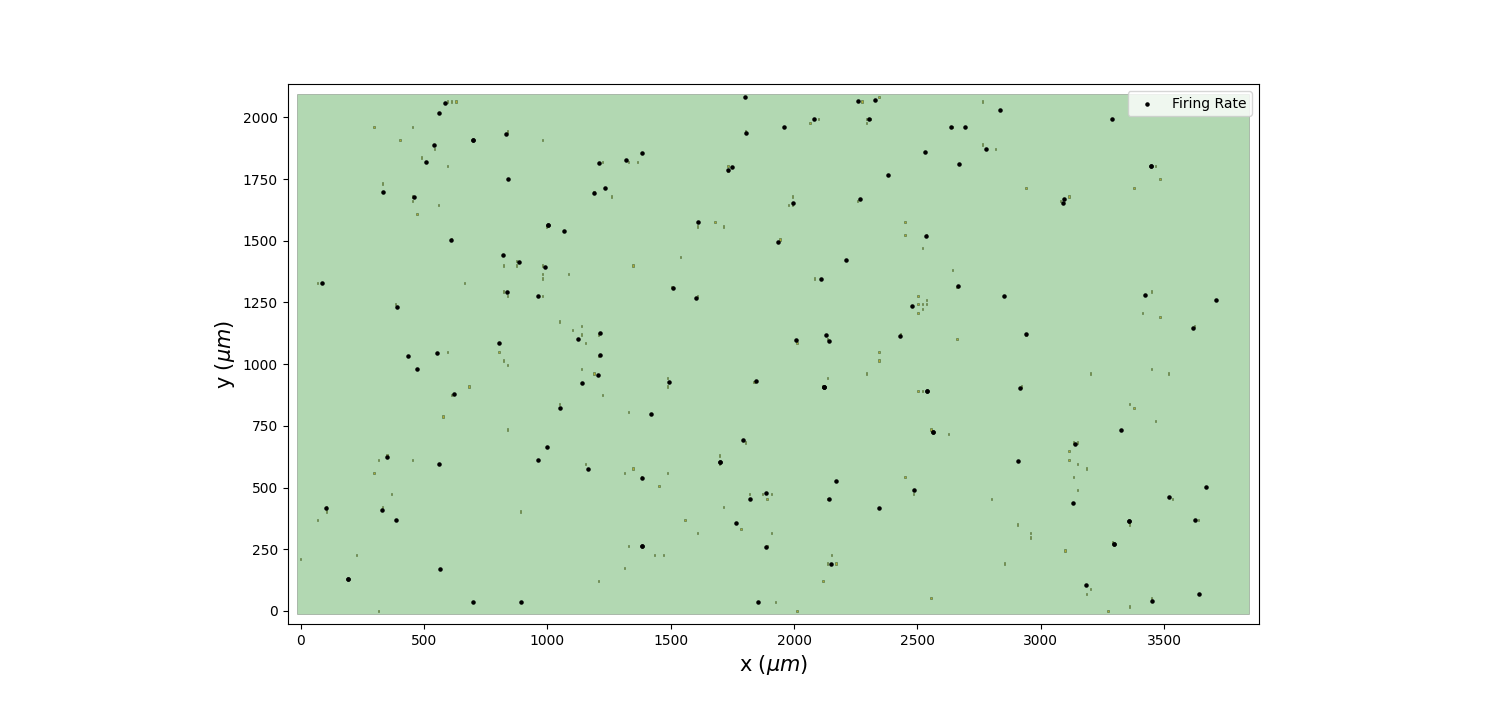

In [13]:
plt.cla()
ax3 = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax3,with_channel_ids=False)

x_values, y_values = zip(*FR_location)
ax3.scatter(x_values, y_values, color='black', s=5,label ='Firing Rate')

ax3.legend()
plt.show()

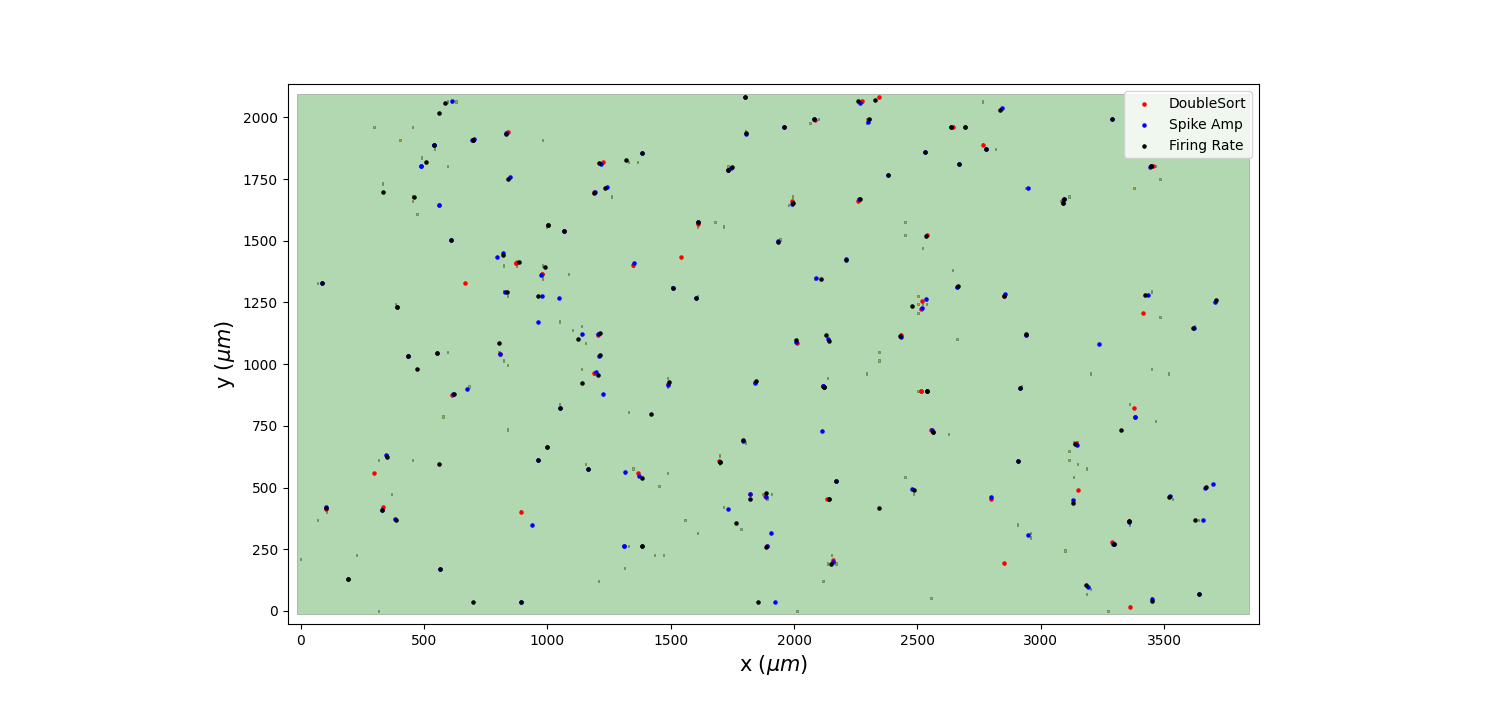

In [10]:
plt.cla()
ax2 = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax2,with_channel_ids=False)
x_values, y_values = zip(*ds_location)
ax2.scatter(x_values, y_values, color='red', s=5, label ='DoubleSort')
x_values, y_values = zip(*SA_location)
ax2.scatter(x_values, y_values, color='blue', s=5,label ='Spike Amp')
x_values, y_values = zip(*FR_location)
ax2.scatter(x_values, y_values, color='black', s=5,label ='Firing Rate')
ax2.legend()
plt.show()

In [ ]:
unit_extremum_channel =spikeinterface.full.get_template_extremum_channel(waveform_good, peak_sign='neg')
#Step 1: keep only units that are in good_units 
unit_extremum_channel = {key:value for key,value in unit_extremum_channel.items() if key in unit_ids}
print(f"extremum channel : {unit_extremum_channel}")

#unique channels and count:
unique_channel_count = set([value for key,value in unit_extremum_channel.items() if key in unit_ids])
print(f"{unique_channel_count} and len : {len(unique_channel_count)}")

#Step3: get units that correspond to same electrodes.
output_units = [[key for key, value in unit_extremum_channel.items() if value == v] for v in set(unit_extremum_channel.values()) if list(unit_extremum_channel.values()).count(v) > 1]
print(f"Units that correspond to same electrode: {output_units}")
#Unique channel

#Step 3: get the metrics

In [ ]:
dic = msp.get_channel_locations_mapping(recording1)
print(dic)

In [ ]:
import importlib
importlib.reload(msp)
importlib.reload(helper)

In [ ]:
electrodes = []
for channel in unique_channel_count:

    x,y = dic[channel][0]/17.5 ,dic[channel][1]/17.5
    surrounding_coordinates = helper.get_surrounding_coordinates(x,y)
    print(len(surrounding_coordinates))
    electrodes.extend(surrounding_coordinates)
print(len(electrodes))
electrodes = set(electrodes)
print(len(electrodes))

In [ ]:
print(type(metrics['amplitude_median'][int('0')]))

In [ ]:
my_list = [[5, 11], [9, 19, 27], [46, 48], [1, 2, 3], [50, 53, 59], [17, 18]]

# Flatten the list using a nested list comprehension
flattened_list = [element for sublist in my_list for element in sublist]

print(flattened_list)

In [ ]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms, peak_sign='neg')
print(extremum_channels_ids)



In [ ]:

output = [[key for key, value in extremum_channels_ids.items() if value == v] for v in set(extremum_channels_ids.values()) if list(extremum_channels_ids.values()).count(v) > 1]
print(output)

In [ ]:


print(helper.get_key_by_value(extremum_channels_ids,'221'))

In [ ]:

isi_violations_ratio, isi_violations_count = qm.compute_isi_violations(waveforms, isi_threshold_ms=1.0)
print(isi_violations_ratio)
print(isi_violations_count)

rp_contamination,rp_violation = qm.compute_refrac_period_violations(waveforms)
print(rp_contamination)
print(rp_violation)
snr_ratio = qm.compute_snrs(waveforms,peak_sign="both", peak_mode='at_index')
print(snr_ratio)

firing_rate = qm.compute_firing_rates(waveforms)
print(firing_rate)

amp_cutoff = qm.compute_amplitude_cutoffs(waveforms)
print(amp_cutoff)

In [ ]:
for i in range(29):
    record_num = str(i).zfill(4)
    record_name = 'rec' + record_num
    print(record_name)

In [ ]:
import helper_functions as helper


filename = 'Extremechannels_4min.json'
helper.dumpdicttofile(extremum_channels_ids,filename)


In [ ]:
violated_units = [unit for unit, ratio in isi_violations_ratio.items() if ratio > 0.0]
print(violated_units)
print(f"isi violated units:{len(violated_units)}")

refrct_violated_units = [unit for unit,ratio in rp_contamination.items() if ratio >0.0]
print(refrct_violated_units)
print(f"refract vio units:{len(refrct_violated_units)}")

In [ ]:
frrate_units = [ unit for unit,ratio in firing_rate.items() if ratio < 0.1]
print(frrate_units)

In [ ]:
deletion_candidates = list(set(violated_units+frrate_units))
print(deletion_candidates)

In [ ]:
print(sorting_KS3)

clean_sorting = sorting_KS3.remove_units(deletion_candidates)
print(clean_sorting)
good_units = [units for units in total_units if units not in deletion_candidates ]
print(good_units)

#now getting the wavefrom extractor

waveform_good = waveforms.select_units(good_units,new_folder='/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/waveforms_good')
print(waveform_good)

In [ ]:
unit_extremum_channel =sp.get_template_extremum_channel(waveforms, peak_sign='neg')
#Step 1: keep only units that are in good_units 
print(unit_extremum_channel)
unit_extremum_channel = {key:value for key,value in unit_extremum_channel.items() if key  in good_units}

print(unit_extremum_channel)
#Step3: get units that correspond to same electrodes.
output_units = [[key for key, value in unit_extremum_channel.items() if value == v] for v in set(unit_extremum_channel.values()) if list(unit_extremum_channel.values()).count(v) > 1]

print(output_units)
output=[]
if output_units :
    for sublist in output_units :
        amp_max = 0 
        for unit in sublist:
            if metrics['amplitude_median'][int(unit)] > amp_max :
                amp_max = metrics['amplitude_median'][int(unit)]
                reqd_unit = unit
        output.append(reqd_unit)
#Step 5 --> unit_extremum_channel - output_units + output
output_units = [element for sublist in output_units for element in sublist]
new_list = [ item for item in output_units if item not in output]

print(f"Output : {output}")

print(f"Output units : {output_units}")

print(f"new list {new_list}")
required_templates = {key:value for key,value in unit_extremum_channel.items() if key not in new_list}
print(f"reqd templates {required_templates}")

In [ ]:
%matplotlib widget

In [ ]:
import spikeinterface.postprocessing as sp

locations = sp.compute_unit_locations(waveforms)
print(type(locations))
import numpy as np
#np.savetxt("unitloc_10mins.txt",locations)
ax = plt.subplot(111)
sw.plot_probe_map(recording1,ax=ax,with_channel_ids=False)
for x,y in locations:
    ax.scatter(x,y)

In [ ]:
import spikeinterface_gui
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()#Need to implement compute noise levels.

In [ ]:
channel_locations = recording_chunk.get_channel_locations()
channel_ids = recording_chunk.get_channel_ids()
_ = [print(f"{channel_id}: {location}") for location, channel_id in zip(channel_locations, channel_ids)]



In [ ]:
fig, ax1 = plt.subplots(figsize=(15,5))
spike_times = {}
for idx, unit_id in enumerate(clean_sorting.get_unit_ids()):
    spike_train = clean_sorting.get_unit_spike_train(unit_id,start_frame=1*fs,end_frame=100*fs)
    print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        ax1.plot(spike_times[idx],idx*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='black')
                       

In [ ]:
t_start = 0 
t_end = int(600*fs)
dt = 1
#initialising the spike train.
units= clean_sorting.get_num_units()
frame_numbers = t_end
spike_array = np.zeros((units,frame_numbers), dtype= int)
for idx, unit_id in enumerate(clean_sorting.get_unit_ids()):
    spike_train = clean_sorting.get_unit_spike_train(unit_id,start_frame=t_start,end_frame=t_end)
    for spike_time in spike_train:
        spike_array[idx,spike_time] = 1

print(spike_array)

print(spike_array[0,63782])

In [ ]:
np.savez_compressed('spike_array_compressed_blockactivity.npz',spike_array)

In [ ]:
with np.load('spike_array_compressed_blockactivity.npz') as data:
    decompressed_data = data['arr_0']

print(np.array_equal(spike_array, decompressed_data))


In [ ]:
extremum_channels_ids =spikeinterface.full.get_template_extremum_channel(waveforms, peak_sign='neg')
print(extremum_channels_ids)



In [ ]:
colors = [ 'Lime','Gold', 'Orange','Orangered']
fig, ax = plt.subplots()
wf=[]
for i, unit_id in enumerate([22,23,27,28]):
    wf = waveforms.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :,channel_association_dict[20]].T, color=color, lw=0.3)
print(wf.shape)

In [ ]:
colors = [ 'Fuchsia','Olive', 'Teal']
fig, ax = plt.subplots()
wf=[]
for i, unit_id in enumerate([218]):
    wf = waveform_good.get_waveforms(unit_id)
    ax.plot(wf[:, :,channel_association_dict[902]].T, color=colors[0], lw=0.3)
    ax.plot(wf[:, :,channel_association_dict[613]].T, color=colors[1], lw=0.3)
    ax.plot(wf[:, :,channel_association_dict[663]].T, color=colors[2], lw=0.3)
print(wf.shape)

In [ ]:
peak_shift=si.get_template_extremum_channel_peak_shift(waveform_good)

print(peak_shift)

In [ ]:
colors = [ 'Fuchsia','Olive', 'Teal']
fig, ax = plt.subplots()
for i, unit_id in enumerate([26, 40 , 46]):
    template = waveforms.get_template(unit_id)
    color = colors[i]
    ax.plot(template[:, channel_association_dict[780]].T, color=color, lw=3)
print(template.shape)

In [ ]:
w = sw.plot_unit_templates(waveform_good, unit_ids=[183],plot_channels=False )

In [ ]:
w = sw.plot_unit_waveforms(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_templates(waveform_good, unit_ids=[2,4,7])
w = sw.plot_unit_probe_map(waveform_good, unit_ids=[2,4,7])

In [ ]:
import spikeinterface_gui
# This creates a Qt app
app = spikeinterface_gui.mkQApp() 

# create the mainwindow and show
win = spikeinterface_gui.MainWindow(waveforms)
win.show()
# run the main Qt6 loop
app.exec_()

